In [11]:
import faceted
import pandas as pd
import xarray as xr

import plotting
import utils

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [2]:
plotting.configure_style()

In [3]:
catalog = utils.open_catalog()
regridder = utils.get_regridder()

In [4]:
CLIMATES = ["1xCO2", "3xCO2"]
INITIAL_CONDITIONS = [f"ic{n}" for n in range(1, 6)]

REFERENCE = "SHiELD-SOM-C96"
ACE2_SOM = "ACE2-SOM-multi-climate-RS3"
BASELINE = "SHiELD-SOM-C24-tuned-cdmbgwd"

MODELS = [REFERENCE, ACE2_SOM, BASELINE]
ONE_DEGREE_MODELS = [REFERENCE, ACE2_SOM]
FILENAME = "autoregressive_predictions.nc"

In [5]:
cases = catalog[
    catalog["initial_condition"].isin(INITIAL_CONDITIONS)
    & catalog["model"].isin(MODELS)
    & catalog["forcing"].isin(CLIMATES)
    & (catalog["tag"] == "extreme-precipitation")
]

In [6]:
datasets = {}
for _, case in cases.iterrows():
    model = case["model"]
    climate = case["forcing"]
    beaker_id = case["beaker_id"]
    initial_condition = case["initial_condition"]
    key = model, climate, initial_condition
    ds = utils.open_beaker_dataset(beaker_id, FILENAME, ["PRATEsfc"])
    if model in ONE_DEGREE_MODELS:
        ds = regridder(ds).drop_vars(["lat", "lon"])
    datasets[key] = ds
index = pd.MultiIndex.from_tuples(
    datasets.keys(), names=("model", "climate", "initial_condition")
)
combined = utils.safe_concat(datasets.values(), dim="case")
ds = combined.assign_coords(case=index).unstack("case")
ds = utils.scale_precipitation(ds)

/home/spencerc/miniconda3/envs/ace2-som-paper2/lib/python3.10/site-packages/beaker/client.py:163: UserWarning: You're using beaker-py v1.32.2, but a newer version (v1.32.3) is available.

Please upgrade with `pip install --upgrade beaker-py`.

You can find the release notes for v1.32.3 at https://github.com/allenai/beaker-py/releases/tag/v1.32.3

  warnings.warn(


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

/tmp/ipykernel_4185/2419145901.py:16: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'case' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  ds = combined.assign_coords(case=index).unstack("case")


In [7]:
COLORS = {REFERENCE: "k", ACE2_SOM: "C0", BASELINE: "C1"}
LABELS = {REFERENCE: "C96 SHiELD-SOM", ACE2_SOM: "ACE2-SOM", BASELINE: "C24 SHiELD-SOM"}

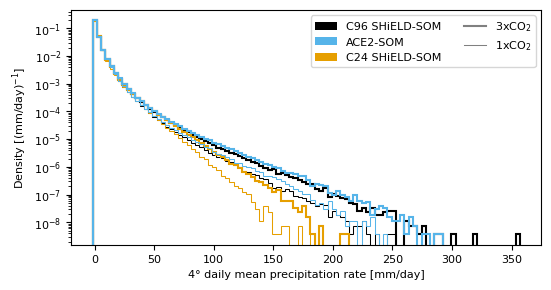

In [8]:
fig, (ax,) = faceted.faceted(
    1,
    1,
    aspect=0.5,
    width=5.5,
    left_pad=0.7,
    right_pad=0.1,
    bottom_pad=0.5,
    top_pad=0.1,
)

kwargs = {"histtype": "step", "yscale": "log", "density": True}

counts_3xCO2 = {}
counts_1xCO2 = {}

counts_3xCO2[REFERENCE], bins, _ = ds.PRATEsfc.sel(
    model=REFERENCE, climate="3xCO2"
).plot.hist(ax=ax, color=COLORS[REFERENCE], bins=100, lw=1.5, **kwargs)
counts_1xCO2[REFERENCE], _, _ = ds.PRATEsfc.sel(
    model=REFERENCE, climate="1xCO2"
).plot.hist(ax=ax, color=COLORS[REFERENCE], bins=bins, lw=0.75, **kwargs)

counts_3xCO2[BASELINE], _, _ = ds.PRATEsfc.sel(
    model=BASELINE, climate="3xCO2"
).plot.hist(ax=ax, color=COLORS[BASELINE], bins=bins, lw=1.5, **kwargs)
counts_1xCO2[BASELINE], _, _ = ds.PRATEsfc.sel(
    model=BASELINE, climate="1xCO2"
).plot.hist(ax=ax, color=COLORS[BASELINE], bins=bins, lw=0.75, **kwargs)

counts_3xCO2[ACE2_SOM], _, _ = ds.PRATEsfc.sel(
    model=ACE2_SOM, climate="3xCO2"
).plot.hist(ax=ax, color=COLORS[ACE2_SOM], bins=bins, lw=1.5, **kwargs)
counts_1xCO2[ACE2_SOM], _, _ = ds.PRATEsfc.sel(
    model=ACE2_SOM, climate="1xCO2"
).plot.hist(ax=ax, color=COLORS[ACE2_SOM], bins=bins, lw=0.75, **kwargs)

ax.set_xlabel("4° daily mean precipitation rate [mm/day]")
ax.set_ylabel("Density [(mm/day)$^{-1}$]")
ax.set_title("")

custom_lines = [
    Patch(facecolor="k"),
    Patch(facecolor="C0"),
    Patch(facecolor="C1"),
    Line2D([0], [0], color="gray", lw=1.5),
    Line2D([0], [0], color="gray", lw=0.75),
]

ax.legend(
    custom_lines,
    ["C96 SHiELD-SOM", "ACE2-SOM", "C24 SHiELD-SOM", "3xCO$_2$", "1xCO$_2$"],
    ncol=2,
)
fig.savefig("figures/figure-06.pdf")
fig.savefig("figures/figure-06.png", dpi=200)


In [13]:
global_extremes = ds.PRATEsfc.quantile(
    0.999, ["lon", "lat", "initial_condition", "time"]
)
global_mean_temperature_change = xr.DataArray([3.36, 3.29, 3.34], dims=["model"], coords=[[ACE2_SOM, BASELINE, REFERENCE]])
(global_extremes.diff("climate") / global_extremes.sel(climate="1xCO2")) / global_mean_temperature_change

<xarray.DataArray (sample: 1, model: 3, climate: 1)> Size: 24B
array([[[0.05965617],
        [0.05641052],
        [0.05868868]]])
Coordinates:
  * model      (model) object 24B 'ACE2-SOM-multi-climate-RS3' ... 'SHiELD-SO...
  * climate    (climate) object 8B '3xCO2'
    init_time  (sample) datetime64[ns] 8B 2031-01-01T21:00:00
    quantile   float64 8B 0.999
Dimensions without coordinates: sample